In [1]:
# Install libraries (run in a code cell, prepend with !)
!pip install -q textblob nltk vaderSentiment wordcloud
# Download required NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
# Robust CSV parser + sentiment pipeline (paste into a new Code cell)
# This cell fixes "Expected 6 fields ... saw 7" by reconstructing Feedback that contains commas.

import io, sys
import pandas as pd

# If 'uploaded' exists (from the previous upload), use it; otherwise ask user to upload again.
try:
    uploaded  # if this name exists, we'll use it
except NameError:
    from google.colab import files
    print("Please upload the CSV file now (feedback_dataset_task3.csv).")
    uploaded = files.upload()

# Get filename (first uploaded file)
fname = list(uploaded.keys())[0]
print("Parsing file:", fname)

# Decode the raw bytes to text
raw = uploaded[fname].decode('utf-8', errors='replace')
lines = raw.splitlines()

# Expect header on first line
if len(lines) == 0:
    raise ValueError("Uploaded file looks empty.")

header = lines[0].strip()
expected_cols = header.split(',')
if len(expected_cols) < 6:
    print("Warning: header has fewer than 6 columns. Header:", header)

rows = []
for idx, line in enumerate(lines[1:], start=2):
    # If the line is empty, skip
    if not line.strip():
        continue
    parts = line.split(',')
    if len(parts) == 6:
        # perfectly formatted row
        rows.append(parts)
    elif len(parts) > 6:
        # Name,Dept,Event,Rating, ... feedback pieces ..., Date
        first4 = parts[:4]
        last = parts[-1]
        feedback = ",".join(parts[4:-1])  # join middle parts back into feedback
        rows.append(first4 + [feedback, last])
    else:
        # fewer than 6 parts (malformed) — try a best-effort recovery
        # pad with empty feedback or date
        parts = parts + [""] * (6 - len(parts))
        rows.append(parts)

# Build DataFrame
df = pd.DataFrame(rows, columns=expected_cols[:6])  # keep first 6 column names
print("Parsed shape:", df.shape)
display(df.head(8))

# --- Continue with cleaning + sentiment (TextBlob + VADER) ---
# If you already ran installs and nltk downloads in a prior cell, this will reuse them.
try:
    from textblob import TextBlob
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    import nltk
    from nltk.corpus import stopwords
except Exception as e:
    print("Missing libs — install and run the install cell, then run this cell again.")
    raise e

# Basic cleaning function
import re
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z0-9\s']", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

df['Feedback'] = df['Feedback'].astype(str)
df['Feedback_clean'] = df['Feedback'].apply(clean_text)

# Sentiment scoring
analyzer = SentimentIntensityAnalyzer()
df['polarity_textblob'] = df['Feedback'].apply(lambda t: TextBlob(t).sentiment.polarity)
df['vader_compound'] = df['Feedback'].apply(lambda t: analyzer.polarity_scores(t)['compound'])

def label_from_score(score, pos_thresh=0.05, neg_thresh=-0.05):
    if score >= pos_thresh:
        return 'Positive'
    elif score <= neg_thresh:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_textblob'] = df['polarity_textblob'].apply(label_from_score)
df['sentiment_vader'] = df['vader_compound'].apply(label_from_score)

def combined_label(row):
    if row['sentiment_textblob'] == row['sentiment_vader']:
        return row['sentiment_vader']
    return row['sentiment_vader']  # prefer VADER when they disagree

df['sentiment'] = df.apply(combined_label, axis=1)

print("\nFinal dataframe preview:")
display(df.head(8))

# Save processed CSV for download
out_name = 'feedback_processed_task3.csv'
df.to_csv(out_name, index=False)
print(f"\nProcessed file saved as: {out_name}")
from google.colab import files
# files.download(out_name)   # uncomment to auto-download in colab


Parsing file: feedback_dataset_task3.csv
Parsed shape: (148, 6)


,Student_Name,Department,Event_Name,Rating,Feedback,Date
0,Aarav,CSE,Workshop on AI,5,The event was very well organized and informat...,2024-01-15
1,Ananya,Biotech,Cultural Fest,4,Great coordination and valuable content.,2024-02-12
2,Rohan,Mechanical,Sports Meet,3,The event was manageable but not very exciting.,2024-03-18
3,Priya,AI&DS,Technical Seminar,2,Coordination was bad and confusing.,2024-04-10
4,Ishita,Civil,Hackathon,1,The session was boring and too long.,2024-02-25
5,Kunal,Pharmacy,Guest Lecture,4,Very interactive and well-structured session.,2024-05-14
6,Simran,IT,Placement Drive,5,Extremely helpful and inspiring event.,2024-06-19
7,Aditya,CSE,Innovation Day,3,"Some parts were good, some parts were dull.",2024-07-08



Final dataframe preview:


,Student_Name,Department,Event_Name,Rating,Feedback,Date,Feedback_clean,polarity_textblob,vader_compound,sentiment_textblob,sentiment_vader,sentiment
0,Aarav,CSE,Workshop on AI,5,The event was very well organized and informat...,2024-01-15,event well organized informative,0.200000,0.3384,Positive,Positive,Positive
1,Ananya,Biotech,Cultural Fest,4,Great coordination and valuable content.,2024-02-12,great coordination valuable content,0.800000,0.8020,Positive,Positive,Positive
2,Rohan,Mechanical,Sports Meet,3,The event was manageable but not very exciting.,2024-03-18,event manageable exciting,-0.115385,-0.5814,Negative,Negative,Negative
3,Priya,AI&DS,Technical Seminar,2,Coordination was bad and confusing.,2024-04-10,coordination bad confusing,-0.500000,-0.6597,Negative,Negative,Negative
4,Ishita,Civil,Hackathon,1,The session was boring and too long.,2024-02-25,session boring long,-0.525000,-0.3182,Negative,Negative,Negative
5,Kunal,Pharmacy,Guest Lecture,4,Very interactive and well-structured session.,2024-05-14,interactive well structured session,0.200000,0.0000,Positive,Neutral,Neutral
6,Simran,IT,Placement Drive,5,Extremely helpful and inspiring event.,2024-06-19,extremely helpful inspiring event,0.187500,0.7316,Positive,Positive,Positive
7,Aditya,CSE,Innovation Day,3,"Some parts were good, some parts were dull.",2024-07-08,parts good parts dull,0.204167,0.0516,Positive,Positive,Positive



Processed file saved as: feedback_processed_task3.csv


In [4]:
# Overall distribution & sentiment by event
dist = df['sentiment'].value_counts()
print("Overall sentiment counts:\n", dist)
print("\nProportions:\n", df['sentiment'].value_counts(normalize=True).round(3))

by_event = df.groupby(['Event_Name','sentiment']).size().unstack(fill_value=0)
by_event['total'] = by_event.sum(axis=1)
by_event_sorted = by_event.sort_values('total', ascending=False)
by_event_sorted.head(10)


Overall sentiment counts:
 sentiment
Positive    87
Negative    44
Neutral     17
Name: count, dtype: int64

Proportions:
 sentiment
Positive    0.588
Negative    0.297
Neutral     0.115
Name: proportion, dtype: float64


sentiment,Negative,Neutral,Positive,total
Event_Name,,,,
Cultural Fest,1,0,14,15
Guest Lecture,3,2,10,15
Technical Seminar,11,1,3,15
Hackathon,4,7,4,15
Innovation Day,4,1,10,15
Placement Drive,4,2,9,15
Workshop on AI,3,1,11,15
Sports Meet,8,1,6,15
Data Analytics Bootcamp,3,2,9,14


In [5]:
# Overall distribution & sentiment by event
dist = df['sentiment'].value_counts()
print("Overall sentiment counts:\n", dist)
print("\nProportions:\n", df['sentiment'].value_counts(normalize=True).round(3))

by_event = df.groupby(['Event_Name','sentiment']).size().unstack(fill_value=0)
by_event['total'] = by_event.sum(axis=1)
by_event_sorted = by_event.sort_values('total', ascending=False)
by_event_sorted.head(10)


Overall sentiment counts:
 sentiment
Positive    87
Negative    44
Neutral     17
Name: count, dtype: int64

Proportions:
 sentiment
Positive    0.588
Negative    0.297
Neutral     0.115
Name: proportion, dtype: float64


sentiment,Negative,Neutral,Positive,total
Event_Name,,,,
Cultural Fest,1,0,14,15
Guest Lecture,3,2,10,15
Technical Seminar,11,1,3,15
Hackathon,4,7,4,15
Innovation Day,4,1,10,15
Placement Drive,4,2,9,15
Workshop on AI,3,1,11,15
Sports Meet,8,1,6,15
Data Analytics Bootcamp,3,2,9,14


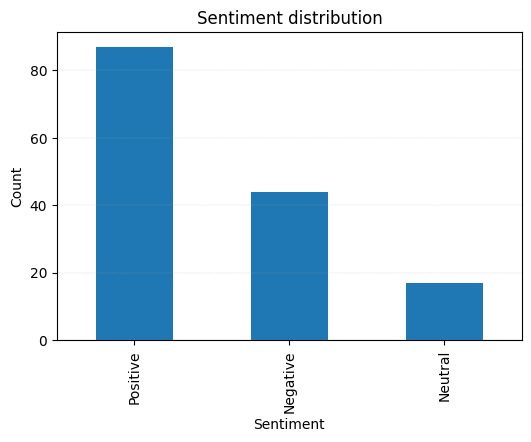

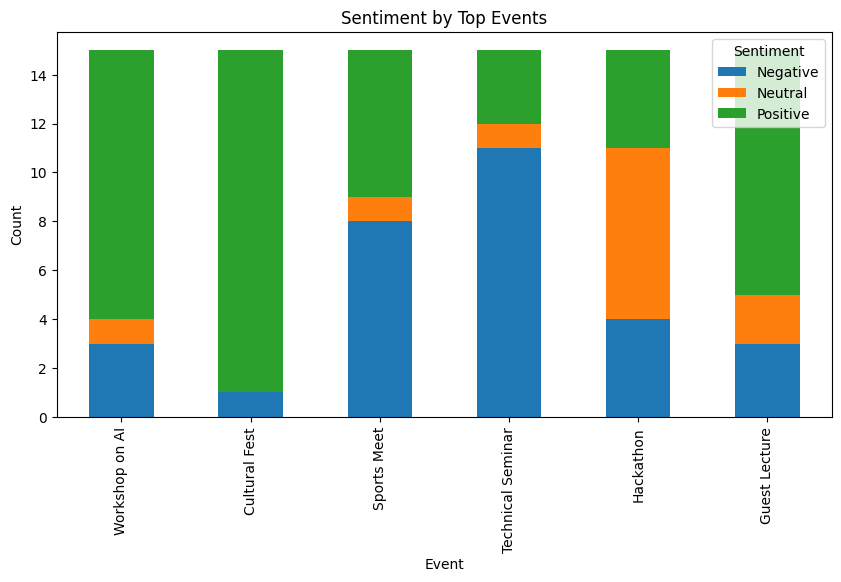

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y', linestyle=':', linewidth=0.3)
plt.show()

top_events = df['Event_Name'].value_counts().nlargest(6).index.tolist()
sub = df[df['Event_Name'].isin(top_events)]
pivot = sub.groupby(['Event_Name','sentiment']).size().unstack(fill_value=0)
pivot = pivot.loc[top_events]

pivot.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Sentiment by Top Events")
plt.xlabel("Event")
plt.ylabel("Count")
plt.legend(title='Sentiment')
plt.show()


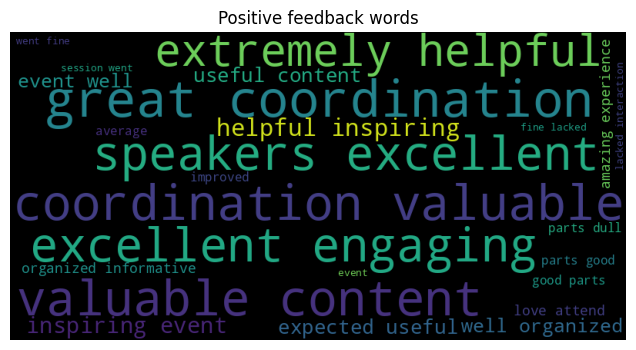

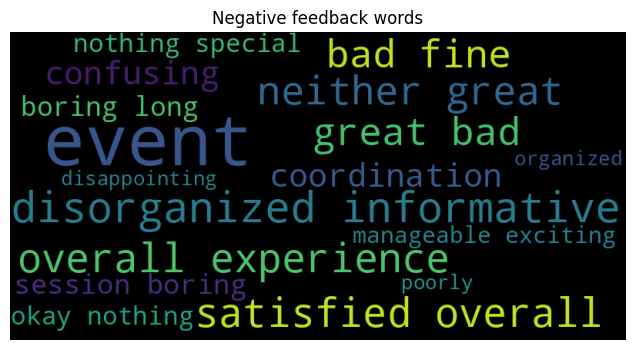

In [7]:
from wordcloud import WordCloud
positive_text = " ".join(df[df['sentiment']=='Positive']['Feedback_clean'].astype(str).tolist())
negative_text = " ".join(df[df['sentiment']=='Negative']['Feedback_clean'].astype(str).tolist())

if positive_text.strip():
    wc = WordCloud(width=800, height=400).generate(positive_text)
    plt.figure(figsize=(10,4)); plt.imshow(wc); plt.axis('off'); plt.title("Positive feedback words"); plt.show()

if negative_text.strip():
    wc = WordCloud(width=800, height=400).generate(negative_text)
    plt.figure(figsize=(10,4)); plt.imshow(wc); plt.axis('off'); plt.title("Negative feedback words"); plt.show()


In [8]:
df.to_csv('feedback_processed_task3.csv', index=False)
from google.colab import files
files.download('feedback_processed_task3.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>